<a href="https://colab.research.google.com/github/clam920/COMP-2800-BBY-08/blob/dev/Binary_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os
import torch
from transformers import BertTokenizer, AutoModelForSequenceClassification
# from transformers import XMLRobertaTokenizer
from transformers import AutoModel, AutoTokenizer
from transformers import RobertaTokenizer

In [ ]:
import torchvision

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory="/content/drive/MyDrive/Garbage classification"
train_directory="/content/drive/MyDrive/Garbage classification/train"
val_directory="/content/drive/MyDrive/Garbage classification/validation"
test_directory="/content/drive/MyDrive/Garbage classification/test"

In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1,
    brightness_range=(0.5,1.5),
    zoom_range = [1, 1.5]
)

val_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

In [ ]:
train_ds=train_datagen.flow_from_directory(train_directory,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  class_mode='sparse',batch_size=32)

val_ds=val_datagen.flow_from_directory(val_directory,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  class_mode='sparse',batch_size=32)

test_ds=test_datagen.flow_from_directory(test_directory,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  class_mode='sparse',batch_size=32)

Found 1567 images belonging to 6 classes.
Found 480 images belonging to 6 classes.
Found 480 images belonging to 6 classes.


In [ ]:
from keras.applications import ResNet101V2

pretrained_model=ResNet101V2(input_shape=(224,224,3),
                             include_top=False,
                             weights='imagenet')

for layer in pretrained_model.layers:
  layer.trainable=False

171317808/171317808 [==============================] - 1s 0us/step


In [ ]:
model=Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(225,activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (Batch  (None, 100352)            401408    
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 225)               22579425  
                                                                 
Total params: 65607393 (250.27 MB)
Trainable params: 22780129 (86.90 MB)
Non-trainable params: 42827264 (163.37 MB)
______

In [ ]:
opt=tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [ ]:
#  model.compile(optimizer=Adam(learning_rate=0.001),
#                loss='categorical_crossentropy',
#                metrics=['accuracy'])

In [ ]:
history=model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
49/49 [==============================] - 554s 11s/step - loss: 2.2705 - accuracy: 0.6305 - val_loss: 1.5083 - val_accuracy: 0.8083
Epoch 2/5
49/49 [==============================] - 36s 730ms/step - loss: 0.9831 - accuracy: 0.8296 - val_loss: 1.7068 - val_accuracy: 0.7833
Epoch 3/5
49/49 [==============================] - 34s 695ms/step - loss: 0.6709 - accuracy: 0.8673 - val_loss: 2.0147 - val_accuracy: 0.7771
Epoch 4/5
49/49 [==============================] - 35s 718ms/step - loss: 0.6278 - accuracy: 0.8915 - val_loss: 2.0522 - val_accuracy: 0.7833
Epoch 5/5
49/49 [==============================] - 34s 692ms/step - loss: 0.7821 - accuracy: 0.8947 - val_loss: 2.8784 - val_accuracy: 0.7792


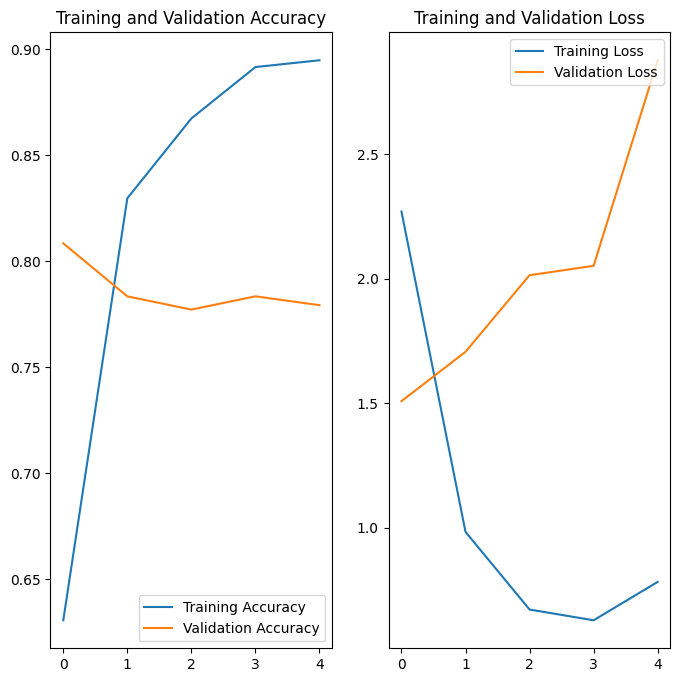

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_data = model.evaluate(
    x=test_ds,
    y=None,
    batch_size=32,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    return_dict=False
)

print(test_data)

15/15 [==============================] - 130s 9s/step - loss: 4.7197 - accuracy: 0.7125
[4.719651222229004, 0.7124999761581421]


In [ ]:
# SAVE MODEL
model_path="/content/drive/MyDrive/Trained Model/model"
model.save(model_path)

In [ ]:
model.save('/content/drive/MyDrive/Trained Model/model/my_model.keras')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Defining list with labels
dic = ['Cardboard', 'Glass', 'Plastic', 'Paper', 'Metal', 'Trash']

Y_pred = model.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_ds.classes, y_pred))

15/15 [==============================] - 5s 299ms/step
              precision    recall  f1-score   support

           0       0.23      0.21      0.22        75
           1       0.22      0.26      0.24        95
           2       0.19      0.29      0.23        80
           3       0.28      0.32      0.30       115
           4       0.10      0.03      0.05        90
           5       0.08      0.04      0.05        25

    accuracy                           0.22       480
   macro avg       0.18      0.19      0.18       480
weighted avg       0.20      0.22      0.20       480



In [ ]:
# Confusion Matrix is a two dimensional matrix that visualizes the performance,
# and makes it easy to see confusion between classes,
# by providing a picture of interrelation

# Each row represents a number of actual, True class
# Each column represents a number of predicted class


# Computing Confusion Matrix to evaluate accuracy of classification
c_m = confusion_matrix(test_ds.classes, y_pred)

# Showing Confusion Matrix in form of 2D Numpy array
print(c_m)

[[16 18 14 22  5  0]
 [11 25 22 24  7  6]
 [11 19 23 20  3  4]
 [ 9 27 34 37  8  0]
 [18 25 22 20  3  2]
 [ 6  2  5  8  3  1]]


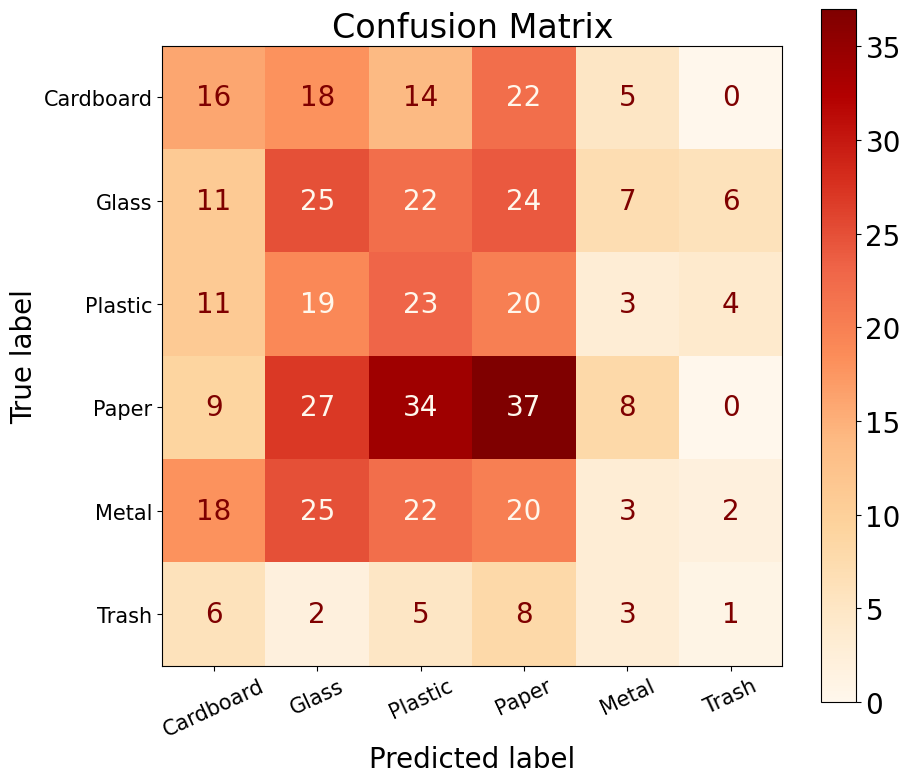

In [ ]:
# Magic function that renders the figure in a jupyter notebook
# instead of displaying a figure object
%matplotlib inline


# Setting default size of the plot
# Setting default fontsize used in the plot
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=dic)


# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving plot
plt.savefig('confusion_matrix.png', transparent=True, dpi=500)


# Showing the plot
plt.show()
